# implement line sweeps of params
- all params fixed expcet one, which is swept over range
- specifically looking at test accuracy as a function of one param


In [1]:
from matplotlib import pyplot as plt
from scipy.special import softmax
from itertools import product

import numpy as np
from utils import *
from model import *
import time
import seaborn as sns
sns.set_context('talk')

%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob as glob
gsname = "gs0825"
L = []
for fp in glob('data/'+gsname+'/*'):
  df_ = pd.read_csv(fp)
  L.append(df_)
gsdf = pd.concat(L)
gsdf.to_csv('data/gsdf-'+gsname+'.csv')

In [3]:
gsdf.loc[:,'mi'] = gsdf.middle-gsdf.interleaved

In [4]:
D10 = gsdf.mi > 0.15
B50 = gsdf.blocked > 0.9
# Ilow = gsdf.interleaved < 0.6

gsdf[D10&B50].sort_values('mi',ascending=False)

,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi
11,11,1.11,5000.0,10.0,0.035,2.0,0.8,1.0,0.99,0.909545,0.580743,0.944889,0.796803,0.785625,0.216060
27,27,2.71,5000.0,10.0,0.110,2.0,0.8,0.8,0.99,1.000000,0.612380,1.000000,0.808939,0.676817,0.196559
17,17,1.71,4000.0,10.0,0.060,2.0,0.8,0.8,1.00,0.993000,0.680750,0.971000,0.876000,0.806500,0.195250
10,10,1.01,4000.0,8.0,0.035,1.0,0.8,1.0,0.99,0.940150,0.619498,0.943395,0.812911,0.633999,0.193412
25,25,2.51,4000.0,10.0,0.085,1.0,0.8,1.0,0.99,1.000000,0.600808,0.974960,0.787151,0.608901,0.186342
15,15,1.51,5000.0,10.0,0.060,1.0,1.0,0.9,0.99,0.975500,0.633602,0.979466,0.815159,0.768531,0.181557
23,23,2.31,4000.0,8.0,0.160,2.0,1.0,0.8,1.00,0.988750,0.548250,1.000000,0.728750,0.706250,0.180500
6,6,0.61,4000.0,8.0,0.035,2.0,1.0,0.8,1.00,0.942000,0.531750,0.968500,0.703250,0.601500,0.171500
26,26,2.61,4000.0,8.0,0.135,2.0,0.8,0.9,1.00,1.000000,0.603750,1.000000,0.769250,0.649000,0.165500
22,22,2.21,4000.0,10.0,0.085,2.0,0.8,1.0,0.99,1.000000,0.508086,0.967001,0.672983,0.561049,0.164897


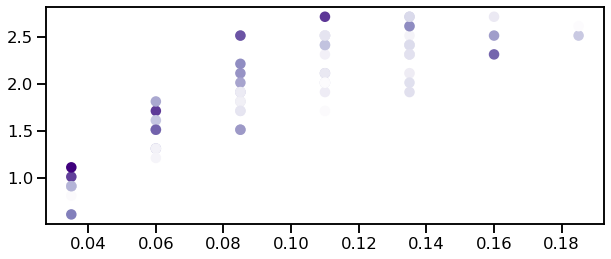

In [20]:
plt.figure(figsize=(10,4))
A = gsdf.blocked>0.9
B = gsdf.middle>gsdf.interleaved
C = gsdf.mi>0.10

pname = 'stickiness_wi'
pvals = [4000,5000]
pname = 'stickiness_bt'
pvals = [8,10]
# pname = 'pvar'
# pvals = [1,2]
# pname = 'lrate'
# pvals = [0.8,1]

D = gsdf.loc[:,pname]==pvals[0]
g = gsdf[A&C]
plt.scatter(g.sparsity,g.concentration,c=g.mi,cmap='Purples')

# D = gsdf.loc[:,pname]==pvals[1]
# g = gsdf[A&B&C&D]
# plt.scatter(g.sparsity,g.concentration,c=g.mi,cmap='Purples',marker='x')


In [6]:
BI = gsdf.blocked > gsdf.interleaved
BM = gsdf.blocked > gsdf.middle
MI = gsdf.middle > gsdf.interleaved
LI = gsdf.late > gsdf.interleaved
B50 = gsdf.blocked > 0.8
M50 = gsdf.middle > 0.7
I60 = gsdf.interleaved < 0.6
gsdf[BI&BM&MI&B50&LI&I60&M50].sort_values(['blocked','middle'],ascending=False)


,Unnamed: 0,concentration,stickiness_wi,stickiness_bt,sparsity,pvar,lrate,lratep,decay_rate,blocked,interleaved,early,middle,late,mi
25,25,2.51,5000.0,8.0,0.160,2.0,1.0,0.8,1.00,1.000000,0.574250,1.000000,0.731500,0.687500,0.157250
24,24,2.41,4000.0,10.0,0.110,1.0,1.0,0.9,1.00,1.000000,0.571750,0.987000,0.713000,0.618250,0.141250
27,27,2.71,4000.0,8.0,0.160,1.0,1.0,0.8,0.99,1.000000,0.594014,1.000000,0.712207,0.701737,0.118193
24,24,2.41,5000.0,10.0,0.110,2.0,1.0,1.0,0.99,1.000000,0.571492,0.987000,0.701449,0.650414,0.129957
23,23,2.31,4000.0,8.0,0.160,2.0,1.0,0.8,1.00,0.988750,0.548250,1.000000,0.728750,0.706250,0.180500
6,6,0.61,4000.0,8.0,0.035,2.0,1.0,0.8,1.00,0.942000,0.531750,0.968500,0.703250,0.601500,0.171500
11,11,1.11,5000.0,10.0,0.035,2.0,0.8,1.0,0.99,0.909545,0.580743,0.944889,0.796803,0.785625,0.216060


In [7]:
assert False

AssertionError: 

In [ ]:
## timestamp and dir for saving
tstamp = time.perf_counter_ns()
import os
os.mkdir('figures/scratch_folders/%i'%tstamp)

In [ ]:
## default params
expargs = {
  'condition':'blocked',
  'n_train':160,
  'n_test':40
}
schargs = {
    'concentration':1.4,
    'stickiness_wi':5000,
    'stickiness_bt':5, # 100
    'sparsity':0.08,
    'pvar': 2,
    'lrate':0.8,
    'lratep':1,
    'decay_rate':1,
} 
args = {
    'sch':schargs,
    'exp':expargs
}
param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
param_str

In [ ]:
gridD = {
  'concentration': [1.4,2.0,2.2],
  'stickiness_wi': [5000],
  'stickiness_bt': [5,10],
  'sparsity': [0.08],
  'pvar': [2],
  'lrate': [1],
  'lratep': [1],
  'decay_rate': [0.99],
}

gridD
## grid
pnames = [i for i in gridD.keys()]
pranges = [i for i in gridD.values()]
for idx,i in enumerate(product(*pranges)):
  d = dict(zip(pnames,i))
  
print('number of param conditions',idx)
print(d)

In [ ]:
i,pnames
# dict(zip(pnames,i))

pvalstr = " ".join([str(j) for j in i])
out = "%s+%s"%(pnames,pvalstr)
out.split('+')[0]
pval

### main

In [ ]:
def pltsave_macc(macc,schargs=None,labL=['B','I','E','M','L'],close=True):
  """ 
  save accuracy of individual parameter setting 
  used in paramsearch loops
  """
  plt.figure(figsize=(10,4))
  ax=plt.gca()
  for idx in range(len(macc)):
    ax.plot(macc[idx],label=labL[idx])
  ax.axhline(0.5,c='k')
  plt.legend()
  param_str = "-".join(["%s_%.3f"%(i,j) for i,j in schargs.items()])
  plt.savefig('figures/scratch_folders/%i/acc-%s.jpg'%(tstamp,param_str))
  if close:
    plt.close('all')
  return None


In [ ]:
ns = 5
dfL = []
condL = ['blocked','interleaved','early','middle','late']
for idx,p_val in enumerate(p_vals):
  print(idx/len(p_vals))
  
  args['sch'][p_name] = p_val  
  exp_batch_data = run_batch_exp_curr(ns,args,condL)
  ## acc
  batch_acc = unpack_acc(exp_batch_data) # curr,seeds,trials
  mean_acc = batch_acc.mean(1)
  test_acc = mean_acc[:,-40:].mean(1) # curr  
  
  ## save traces of EML for each param setting
  pltsave_macc(mean_acc[2:],args['sch'],labL=['E','M','L'])
  
  ## record
  gsD = {
    **schargs,
    **dict(zip(condL,test_acc))
  }
  dfL.append(gsD)
  
gsdf = pd.DataFrame(dfL)

In [ ]:
gsdf.to_csv('data/gsdf%i.csv'%tstamp)
gsdf ## test acc dataframe

In [ ]:
BI = gsdf.blocked > gsdf.interleaved
BM = gsdf.blocked > gsdf.middle
MI = gsdf.middle > gsdf.interleaved
gsdf[BI&BM&MI]